# Data Processing

## Import libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy import stats
from scipy.stats import norm, skew

warnings.filterwarnings('ignore')
color = sns.color_palette()
sns.set_style('darkgrid')
%matplotlib inline

## GET train dataset

In [9]:
df = pd.read_csv('./dataset/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Target variable

In [11]:
def display_dist(series: pd.Series, col_name: str):
    """
    Display an histogram and a normal probability plot
    
    :param series: pd.Series
    :param col_name: str
    """
    sns.distplot(series , fit=norm);

    plt.ylabel('Frequency')
    plt.title(f'{col_name} distribution')

    fig = plt.figure()
    res = stats.probplot(series, plot=plt);

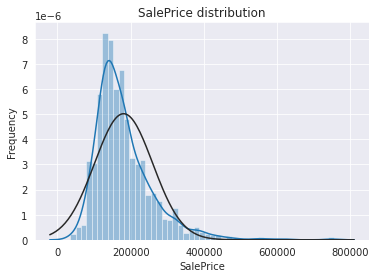

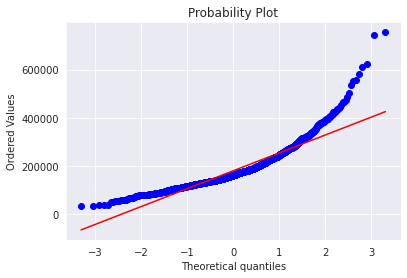

In [12]:
display_dist(df.SalePrice, 'SalePrice')

SalePrice distribution is right skewed and does not follow the diagonal line.     
We need to transform her into a more normally distributed variable for linear model. 

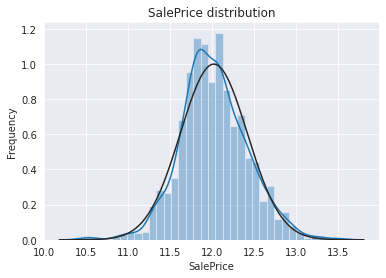

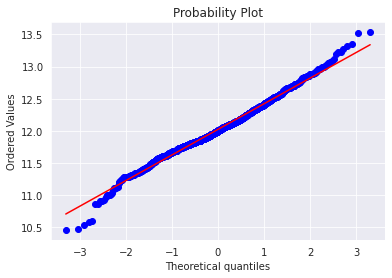

In [13]:
# We use log because the min value is above 30k, no need of log1p
df["SalePrice"] = np.log(df["SalePrice"])

display_dist(df['SalePrice'], 'SalePrice')

## Missing values

In [15]:
total = df.isnull().sum()
total = total[total.values > 0].sort_values(ascending=False)

percent = round((total / len(df)) * 100, 4)

missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,99.5205
MiscFeature,1406,96.3014
Alley,1369,93.7671
Fence,1179,80.7534
FireplaceQu,690,47.2603
LotFrontage,259,17.7397
GarageType,81,5.5479
GarageYrBlt,81,5.5479
GarageFinish,81,5.5479
GarageQual,81,5.5479


## Correlation

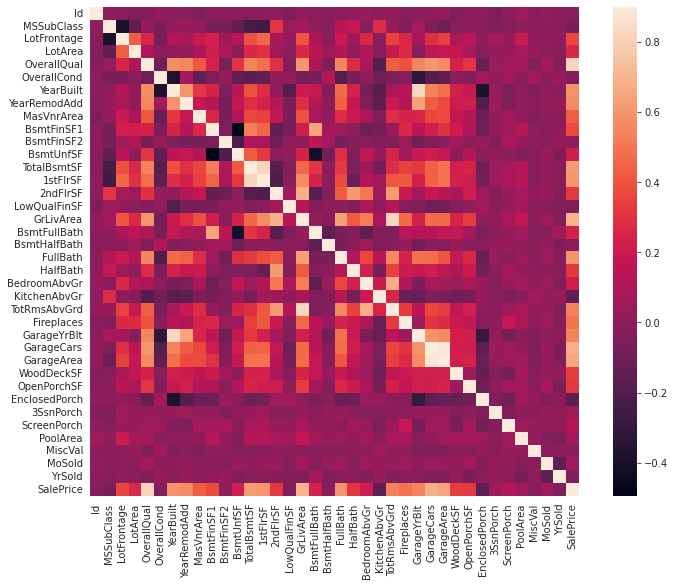

In [17]:
corrmat = df.corr()
plt.subplots(figsize=(12,9))

# Max corr is 0.882475414281462
sns.heatmap(corrmat, vmax=.9, square=True);

Probably multicollinearity between 'TotalBsmtSF' - '1stFlrSF' variables and 'GarageX' variables.    
SalePrice have a correlation with 'GrLivArea', 'GarageX', and 'OverallQual' variables.

## Skewed

In [19]:
numeric_feats = df.dtypes[df.dtypes != "object"].index

skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' : skewed_feats})

skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewness.head(10)

There are 38 skewed numerical features to Box Cox transform


,Skew
MiscVal,24.451640
PoolArea,14.813135
LotArea,12.195142
3SsnPorch,10.293752
LowQualFinSF,9.002080
KitchenAbvGr,4.483784
BsmtFinSF2,4.250888
ScreenPorch,4.117977
BsmtHalfBath,4.099186
EnclosedPorch,3.086696


## Scatter plot

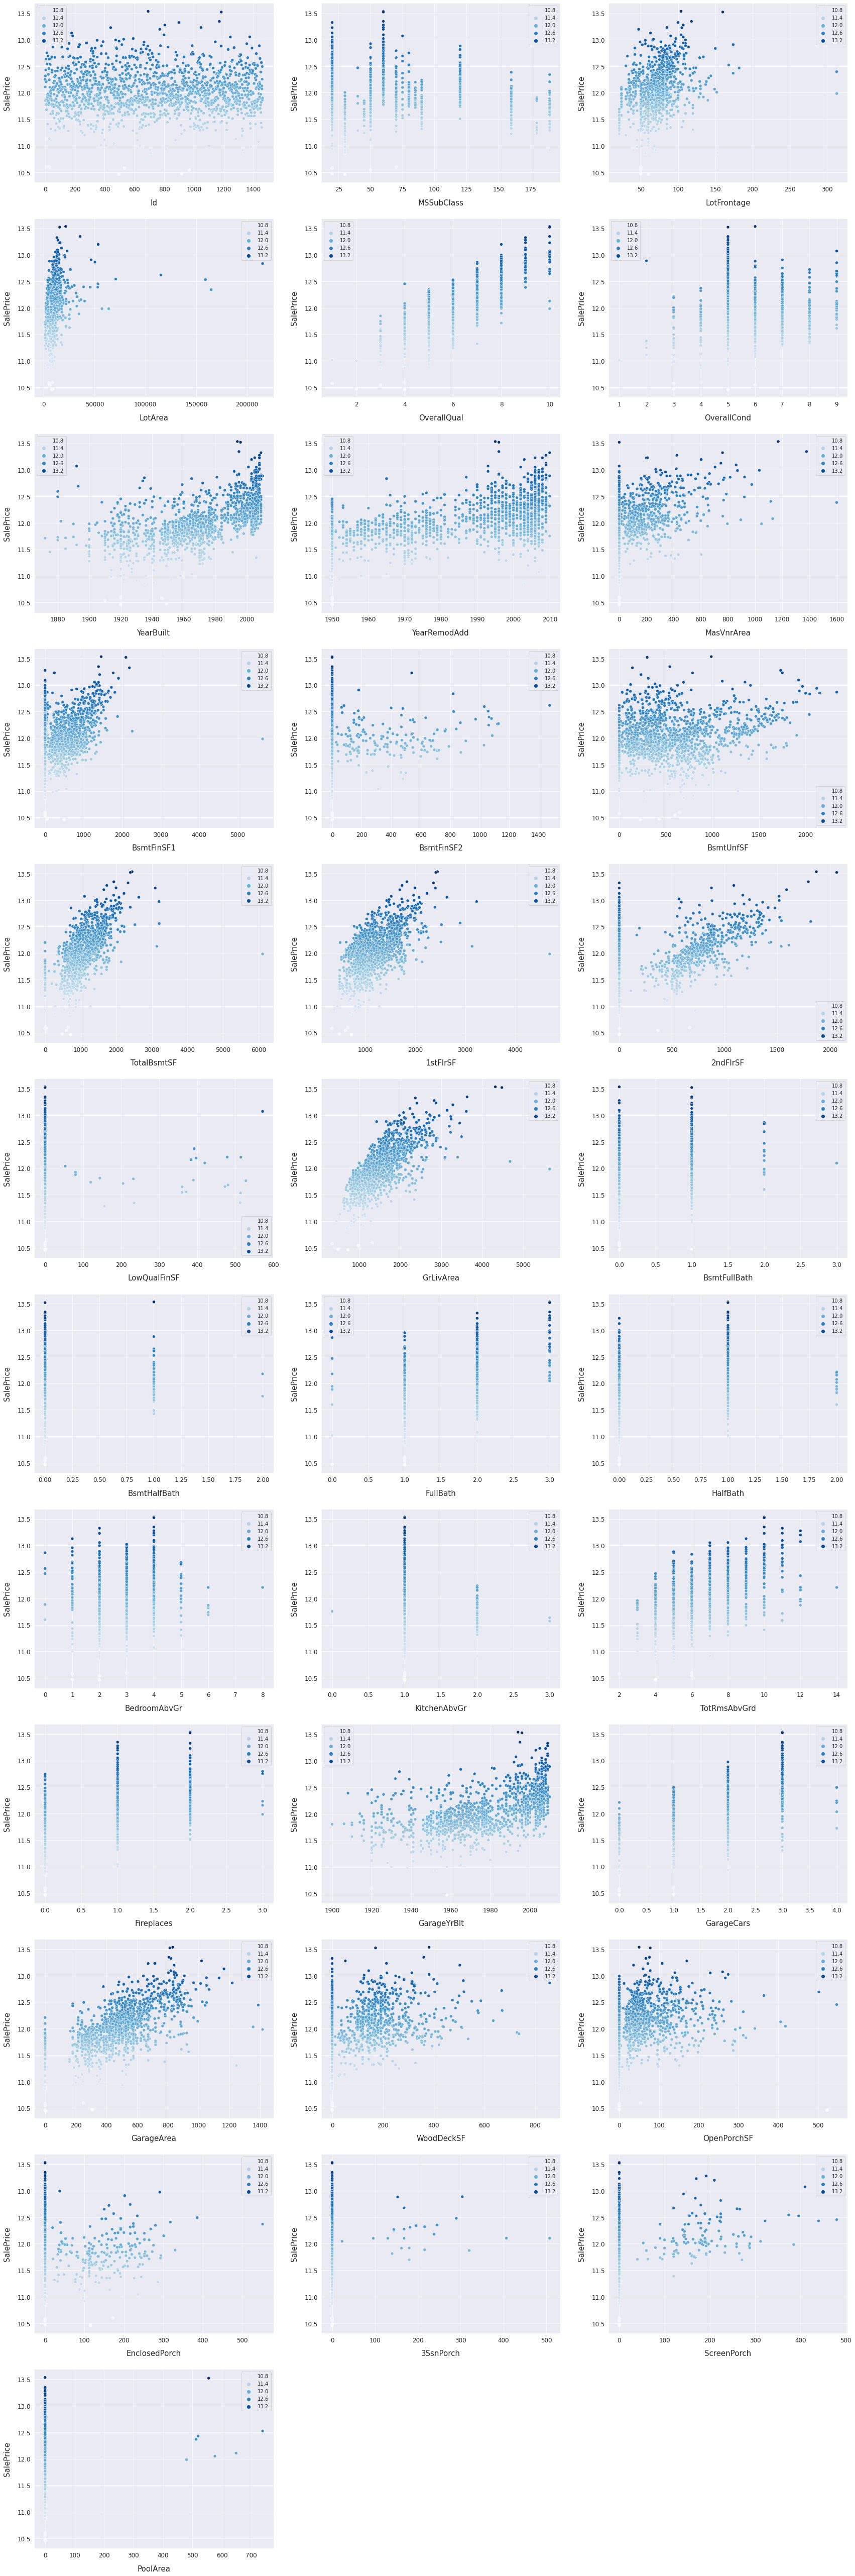

In [42]:
numeric = [
    i
    for i in df.columns 
    if df[i].dtype != 'O'
]

fig, axs = plt.subplots(ncols=2, figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

for i, feature in enumerate(numeric, 1):
    # Same values
    if feature == 'MiscVal':
        break
        
    plt.subplot(len(numeric), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Blues', data=df)
        
    plt.xlabel('{}'.format(feature), size=15, labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC